In [1]:
import numpy as np
import xarray as xr
import cftime
import matplotlib.pyplot as plt

In [2]:
exp_path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/"
file_v= "atmos/ts/monthly/5yr/atmos.011*vcomp.nc"
file_p= "atmos/ts/monthly/5yr/atmos.011*ps.nc"

file_atmos= "atmos/atmos.static.nc"

In [4]:
ds_v = xr.open_mfdataset(f"{exp_path}{file_v}", use_cftime=True)
ds_ps = xr.open_mfdataset(f"{exp_path}{file_p}", use_cftime=True)

ds_static = xr.open_mfdataset(f"{exp_path}{file_atmos}")

In [5]:
lat = ds_v.lat
lon = ds_v.lon
V = ds_v.vcomp.chunk({"lon":576, "time":60, "lat":30, "pfull":11})
pres_= ds_v.pfull
PS = ds_ps.ps

In [6]:
V_bar = V.mean(dim=("time","lon"))
V_bar

<xarray.DataArray 'vcomp' (pfull: 33, lat: 360)>
dask.array<mean_agg-aggregate, shape=(33, 360), dtype=float32, chunksize=(11, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * pfull    (pfull) float64 2.164 5.845 10.75 17.11 ... 975.6 985.4 992.8 997.9

In [7]:
V_bar = V_bar.load()
PS_bar = PS.mean(dim={"time", "lon"}).load()

# Need to integrate from top down to create overturning streamfunction

$\Psi = \int_{TOA}^{p_0} [v] dp \cdot \frac{2 \pi R \cos(\theta)}{g}$

Levels are in pressure coordinates (noted on pfull levels) and are irregularly spaced - so to approximate the depth of each pressure layer I have taken the half-levels (as set out by atmos.static.nc) and converted from mbar to Pa

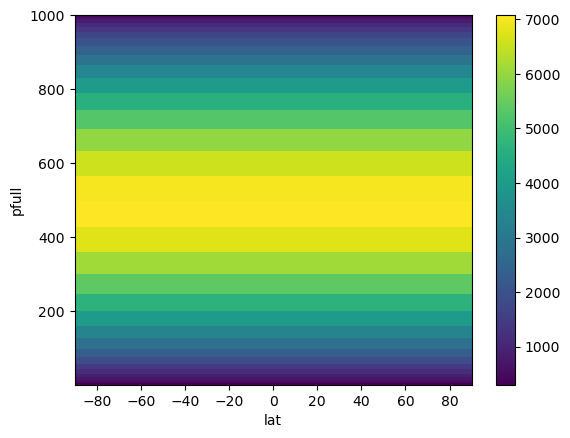

In [8]:
dp = ds_static.phalf[1:].data - ds_static.phalf[:-1].data
dp_2d = np.zeros((33,360))
mbar2pa = 100
for i in np.arange(360):
    dp_2d[:,i] = dp*mbar2pa
    
dp_2d = xr.DataArray(dp_2d,
                    coords=[("pfull", V_bar.pfull.data), ("lat", V_bar.lat.data)])
dp_2d.plot()

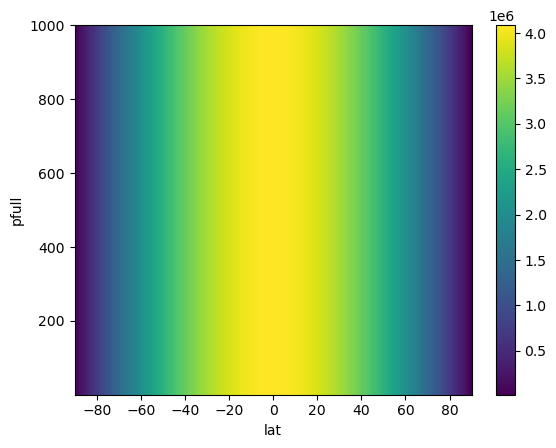

In [9]:
g   = 9.81e0
R   = 6.38e6
lat_rad = V_bar.lat.data* np.pi/180

conv = 2*np.pi*R*np.cos(lat_rad)/g
conv_2d = np.zeros((33,360))
for i in np.arange(33):
    conv_2d[i,:] = conv
    
conv_2d = xr.DataArray(conv_2d, 
                      coords=[("pfull", V_bar.pfull.data), ("lat", V_bar.lat.data)])

conv_2d.plot()

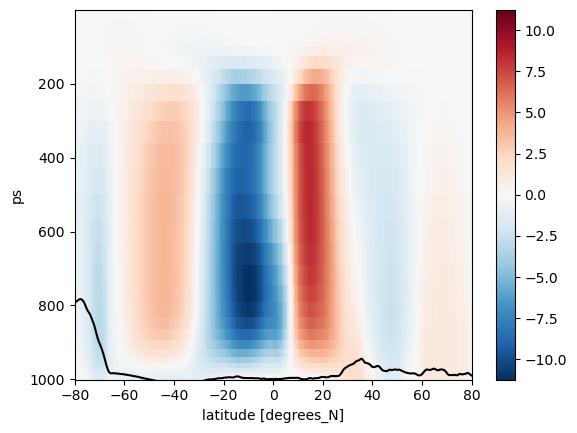

In [10]:
(conv_2d*((V_bar*dp_2d).cumsum(dim="pfull"))/1e10).plot(yincrease=False)
(PS_bar/100).plot(color='k')
plt.xlim([-80, 80])
plt.savefig("overturning_test2.png", format="png", dpi=100)

Below is code found online -- uses NCL algorithm to compute streamfunction on half-levels

In [ ]:
# calculate and plot atmospheric meridional stream function
# Eli, 202012, converted from zon_mpsi.f from web, from NCL

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib
from netCDF4 import Dataset
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
import pickle
from zonal_mpsi import zonal_mpsi


########################################################################
def zonal_mpsi(mlon,nlat,klev,v,lat,p,ps):
########################################################################
    # calculate atmospheric meridional stream function
    # input v needs to be in pressure coordinates
    zmpsi=np.zeros((nlat,klev))
    ptmp=np.zeros(2*klev+1)
    dp=np.zeros(2*klev+1)
    vvprof=np.zeros(2*klev+1)
    vbar=np.zeros((nlat,klev))
    vtmp=np.zeros((mlon,nlat,klev))

    g   = 9.80616e0
    a   = 6.37122e6
    pi  = 4.e0*np.arctan(1.e0)
    rad = pi/180.e0
    con = 2.e0*pi*a/g

    # calculate presssure at all levels [even half levels]

    knt = -1
    #do kl = 1,2*klev - 1,2
    for kl in range(0,2*klev - 2,2):
        knt = knt + 1
        ptmp[kl] = p[knt]
    
    #do kl = 2,2*klev - 2,2
    for kl in range(1,2*klev - 2,2):
        ptmp[kl] = (ptmp[kl+1]+ptmp[kl-1])*0.5e0
    
    ptmp[0] = p[0] # ptop
    ptmp[2*klev] = p[-1] # pbot
    
    # dp at all levels
    
    dp[0] = 0.e0
    #do kl = 1,2*klev - 1
    for kl in range(1,2*klev - 1):
        dp[kl] = ptmp[kl+1] - ptmp[kl-1]
    dp[2*klev] = 0.e0
    
    # make copy; set any p > ps to NaN:
        
    vtmp=1.0*v
    p3d=0.0*v+p
    ps3d=0.0*v
    for kkk in range(len(p)):
        ps3d[:,:,kkk]=ps
    vtmp[p3d>ps3d]=np.nan
    
    # compute zonal mean v using the vtmp variable
    vbar=np.nanmean(vtmp,axis=0)
    
    # compute mpsi at each latitude [reuse ptmp]
    
    #do nl = 1,nlat
    for nl in range(1,nlat):
        c = con*np.cos(lat[nl]*rad)
    
        ptmp[0] = 0.0e0
        #do kl = 1,2*klev
        for kl in range(1,2*klev+1):
            ptmp[kl] = np.nan
    
        #do kl = 0,2*klev,2
        for kl in range(0,2*klev+2,2):
            vvprof[kl] = 0.0e0
    
        knt = 0
        #do kl = 1,2*klev - 1,2
        for kl in range(1,2*klev-1,2):
            knt = knt + 1
            vvprof[kl] = vbar[nl,knt]
    
        # integrate from top of atmosphere down for each level where vbar
        # is not missing

        stop=False
        #do kl = 1,2*klev - 1,2
        for kl in range(1,2*klev - 1,2):
            if ((not stop) and (np.isnan(vvprof[kl]))):
                stop=True
            if not stop:
                kflag = kl
                ptmp[kl+1] = ptmp[kl-1] - c*vvprof[kl]*dp[kl]
    
        # impose lower boundary condition to ensure the zmpsi is 0
        # at the bottom boundary
    
        ptmp[kflag+1] = -ptmp[kflag-1]
    
        # streamfunction is obtained as average from its values
        # at the intermediate half levels. the minus sign before
        # ptmp in the last loop is to conform to a csm convention.

        #do kl = 1,kflag,2
        for kl in range(1,kflag,2):
            ptmp[kl] = (ptmp[kl+1]+ptmp[kl-1])*0.5e0

        knt = 0
        #do kl = 1,2*klev - 1,2
        for kl in range(1,2*klev - 1,2):
            knt = knt + 1
            if (not np.isnan(ptmp[kl])): # then
                zmpsi[nl,knt] = -ptmp[kl]
            else:
                zmpsi[nl,knt] = ptmp[kl]

    return zmpsi,vbar

########################################################################
# Main program
########################################################################

print("reading data...")

filename_V="/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/V/"+"b.e11.B1850C5CN.f09_g16.005.cam.h0.V.040001-049912.nc"
filename_PS="/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PS/"+"b.e11.B1850C5CN.f09_g16.005.cam.h0.PS.040001-049912.nc"
ncfile_V = Dataset(filename_V, 'r');
ncfile_PS = Dataset(filename_PS, 'r');
lat = np.asarray(ncfile_V.variables['lat'][:])
lon = np.asarray(ncfile_V.variables['lon'][:])
V = ncfile_V.variables['V']
pres_=np.asarray(ncfile_V.variables['lev'][:])
PS = ncfile_PS.variables['PS']
showtop=5
showbottom=950
Nz=len(pres_)
indices=np.asarray(range(Nz))
indpres=indices[np.logical_and(pres_>showtop,pres_<showbottom)]
pres=pres_[indpres]
PI=3.14159265
phi = lat*PI/180.0     # latitude in radians
nlat=len(lat)
V=1.0*V[0,indpres,:,:]
V=1.0*V.transpose(2,1,0)
PS=1.0*PS[0,:,:]
PS=1.0*PS.transpose(1,0)

# Calculate meridional circulation
print("calculating psi...")
vmsg=1.e36
mlon,nlat,klev=V.shape
psi,vbar=zonal_mpsi(mlon,nlat,klev,V,lat,pres*100,PS) # multiply by 100 because pres is in mb
psi[np.abs(psi)>1.e30]=np.nan

print("plotting...")
fig=plt.figure(figsize=(5,5),dpi=300)
plt.set_cmap('bwr')
levels=np.arange(-140,150,10)
plt.contourf(lat,pres,psi.T/1.e9,levels=levels,extend='both')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xticks(ticks=range(-90,120,30))
plt.xlabel("Latitude")
plt.ylabel("Pressure (hPa)")
plt.title("Meridional streamfunction (Sv)")
plt.pause(1)
fig.savefig("Output/streamfunction_python.pdf")
